In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import pyplot
from numpy import random
import pandas as pd
from mpmath import mp
from mpl_toolkits import mplot3d
import time 
from tqdm import tqdm 
from copy import copy

In [2]:
df = pd.read_csv('all_distributions_samples.csv')
binomial_sample_values = df['binomial_sample'].to_numpy()
geometric_sample_values = df['geometric_sample'].to_numpy()
poisson_sample_values = df['poisson_sample'].to_numpy()
all_dists = ['poisson_sample', 'binomial_sample', 'geometric_sample']

In [3]:
arr_b = []
arr_p = []
arr_g = []
rew_b = []
def func(s, ss, dist):
    max_ss = max(ss)
    if dist == 'binomial_sample':
        diff_arr = [0,0,0,0]
        for i in range(len(s)):
            diff_arr[i] = ss[i] - s[i]
        for i in range(4):
            if (diff_arr[i] != 0) and s[i] != np.max(s):
                arr_b.append(0)
            else:
                arr_b.append(1)
    elif dist == 'geometric_sample':
        diff_arr = [0,0,0,0]
        for i in range(len(s)):
            diff_arr[i] = ss[i] - s[i]
        for i in range(4):
            if (diff_arr[i] != 0) and s[i] != np.max(s):
                arr_g.append(0)
            else:
                arr_g.append(1)
    elif dist == 'poisson_sample':
        diff_arr = [0,0,0,0]
        for i in range(len(s)):
            diff_arr[i] = ss[i] - s[i]
        for i in range(4):
            if (diff_arr[i] != 0) and s[i] != np.max(s):
                arr_p.append(0)
            else:
                arr_p.append(1)
                

In [4]:
class envir():
    def __init__(self):
        self.phi = 4
        self.S = np.array([1,1,1,1])
    
    def step(self,task,s,jobsize,dist):
        s_old = s[task]
        reward = 0
#         print(s_old,jobsize[task])
        if(s_old==jobsize[task] or s_old==0):
            s_new = 0
        else:
            s_new = s_old+1
        
        if(s_old==0):
            reward = -5
        elif(s_old!=0 and s_new!=0):
            reward = 0
        else:
            reward = 1

        new_state = [0,0,0,0]
        for i in range(4):
            if i==task:
                new_state[i] = s_new
            else:
                new_state[i] = s[i]
        func(s, new_state, dist)
        return new_state,reward
    
    def getjob(self, dist, job_counter):
        
        if dist == 'binomial_sample':
            ret = binomial_sample_values[job_counter * 4 : job_counter * 4 + 4]
             
        elif dist == 'geometric_sample':
            ret = geometric_sample_values[job_counter * 4 : job_counter * 4 + 4]
        
        elif dist == 'poisson_sample':
            ret = poisson_sample_values[job_counter * 4 : job_counter * 4 + 4]
            
        return ret


In [5]:
class Agent():
    def __init__(self,alpha,gamma):
        self.Q_values = np.zeros((6,2,6))
        self.phi = 4
        self.S = np.array([6,6,6,6])
        self.alpha = alpha
        self.gamma = gamma

In [6]:
def select_task(s,M):
        k = []
        for i in range(4):
            k.append(M[s[i]])
        #print(k)
        max_index = np.argmax(k)  # Get the index of the maximum value
        return max_index

def choose_arm(s,W,epsilon):
        wl= []
        p = np.array([0,0,0,0])
        if np.random.random() < epsilon:
            for i in range(len(p)):
                if s[i]!=0:
                    wl.append(i)
            arm_to_pull = np.random.choice(wl,1)[0]
            return arm_to_pull
        else:
            p2 = {}
            for i in range(len(p)):
                if s[i]!=0:
                    p2[i] = W[s[i]]
            max_key = max(p2, key=p2.get)
            return max_key
    

In [7]:
def calculate_count(service, size, new_service):
    count = 0
    count2 = 0
    max_value = np.max(service)
    flag = 0
    count_max = np.sum(service == max_value)
    if count_max == 1:
        for i in range(4):
            if np.argmax(service) == i:
                if service[i]+1 == new_service[i] or new_service[i] == 0:
                    count += 0
                else:
                    count += 1
    else:
        for i in range(4):
            if np.max(service) == service[i]:
                if service[i]+1 == new_service[i] or new_service[i] == 0:
                    flag = 1
        if flag == 0:
            count += 1
    return count



100%|███████████████████████████████████| 20000/20000 [00:02<00:00, 7393.81it/s]


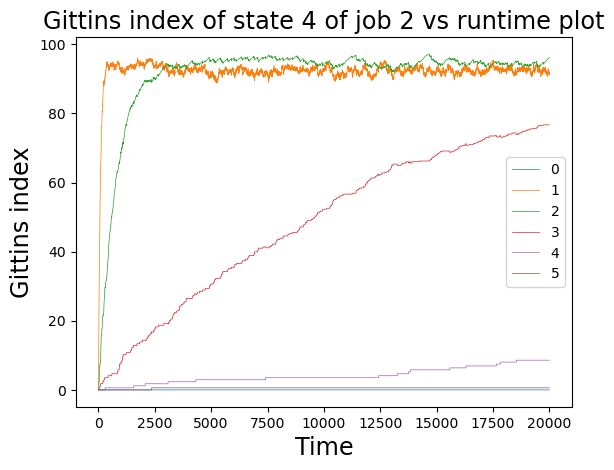

[ 0.         91.2179171  96.2229318  76.68295221  8.59677335  0.599596  ]


In [8]:
hist01_b = [ []*2 for i in range(6)]
ti_b = []
hist01_p = [ []*2 for i in range(6)]
ti_p = []
hist01_g = [ []*2 for i in range(6)]
ti_g = []
regret_arr_b = []
regret_arr_g = []
regret_arr_p = []
class game():
    for dist in all_dists:
        start_time = time.time()
        M = np.zeros((6))
        '''for i in range(100):
            for j in range(9):
                M[i][j] = 0'''
        c0 = 0
        hist01 = []
        ti = []
        c1 = 0
        m = 0
        Q_values = np.zeros((6,6))
        m1 = 0
        ct = 0
        F = np.zeros((6))
        env = envir()
        trials = 20000
        tries = 0
        eps_decay = 0.9999
        epsilon = 1
        agent = Agent(alpha = 0.6,gamma = 0.99)
        job_counter = 0
        for trial_no in tqdm(range(trials)):
            s = np.array([1,1,1,1])
            #Calculating Q values over state space for a given arm for the given M vector through Q learning
            #for step in range(2):
            #print(tries,trial_no)
            epsilon = (eps_decay**trial_no)*epsilon
            jobsize = env.getjob(dist,job_counter)
            tries = 0 
            regret_sum = 0
            while (s[0]!=0 or s[1]!=0 or s[2]!=0 or s[3]!=0):
                tries += 1 
                # UNcomment and comment according to approaches 1 and 2
#                 task = select_task(s = s, M = M )
                task = choose_arm(s = s,W  = M,epsilon = epsilon)
                current_time = time.time()-start_time
                next_state, R = env.step(task,copy(s),jobsize,dist)
                counter = calculate_count(s, jobsize, next_state)
                regret_sum += counter
                for k in range(6):
                    Q_values[s[task]][k] += agent.alpha*(R+agent.gamma*(max(M[k],copy(Q_values[next_state[task]][k])))-Q_values[s[task]][k])    
                if((trial_no%50)==0):
                    agent.alpha = agent.alpha-0.000002
                s= copy(next_state) 

              #Algorithm for stochastic approximation

              #Calculating F
                for i in range(6):
                    F[i]= -M[i]+Q_values[i][i]
                    #print('F',F[i][task])
                    #print('m',M[i][task])
                    #print('q',Q_values[i][i][task])

              #Print values
                #print("Iteration no",t)
                #print("F",F)

              #Update M
                for i in range(6):
                    M[i] = M[i] + 0.3*(F[i])       
                hist01.append(0.01*M[4])
                ti.append(current_time)
            
#             regret_arr.append(regret_sum)
            if dist == 'binomial_sample':
                regret_arr_b.append(regret_sum)
            elif dist == 'poisson_sample':
                regret_arr_p.append(regret_sum)
            elif dist == 'geometric_sample':
                regret_arr_g.append(regret_sum)
            for i in range(6):
                M[i] = M[i] + 0.2*(F[i])       
                if dist == 'binomial_sample':
                    hist01_b[i].append(M[i])
                elif dist == 'poisson_sample':
                    hist01_p[i].append(M[i])
                elif dist == 'geometric_sample':
                    hist01_g[i].append(M[i])
                ti_g.append(current_time)
                ti_b.append(current_time)
                ti_p.append(current_time)
              #Stopping criteria
              #For M[i]
                '''if(t>=10):
                    if(F[0]==0 and (histV0[len(histV0)-1]-histV0[len(histV0)-5]<0.1)):
                        ct=1;
                        m=M[0]   
              #For algorithm
                print(" ")
                histm0.append(M[0])
                histm1.append(M[1])
                if ((np.linalg.norm(F)<.9) or t>=9000) and (t>=2 and np.linalg.norm(V-Vold)<0.1):
                    print("Gittin's index for state 0 is",0.2*min(m,(M[0])))
                    print("Gittin's index for state 1 is",0.2*(M[1]))
                    break'''
            job_counter += 1
    plt.title('Gittins index of state 4 of job 2 vs runtime plot',fontsize='xx-large')
    plt.xlabel('Time', fontsize = 'xx-large')
    plt.ylabel('Gittins index',fontsize = 'xx-large')
    for i in range(6):
        plt.plot(hist01_g[i],'-', label=str(i), linewidth=0.5)
    plt.legend()
    plt.show()
    print(M)

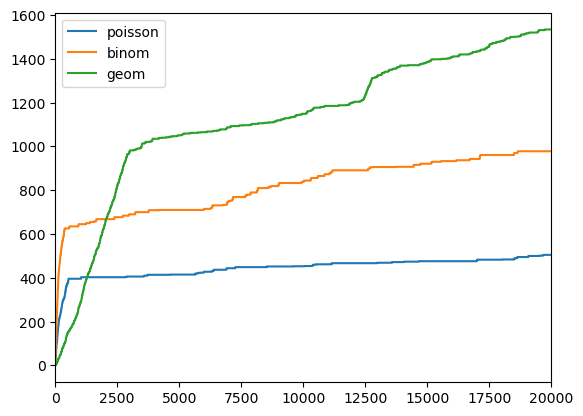

In [9]:
cum_regret_p = []
cum_regret_p.append(regret_arr_p[0])
cum_regret_b = []
cum_regret_b.append(regret_arr_b[0])
cum_regret_g = []
cum_regret_g.append(regret_arr_g[0])
for i in range(1,20000):
    cum_regret_p.append(cum_regret_p[i-1] + regret_arr_p[i])
    cum_regret_b.append(cum_regret_b[i-1] + regret_arr_b[i])
    cum_regret_g.append(cum_regret_g[i-1] + regret_arr_g[i])
plt.plot(cum_regret_p, label = 'poisson')
plt.plot(cum_regret_b, label = 'binom')
plt.plot(cum_regret_g, label = 'geom')
plt.xlim([0, 20000])
plt.legend()
plt.show()

In [10]:
df_cum_regret_p = pd.DataFrame(np.transpose(cum_regret_p), columns =['Retire_Reg_P'])
df_cum_regret_b = pd.DataFrame(np.transpose(cum_regret_b), columns =['Retire_Reg_B'])
df_cum_regret_g = pd.DataFrame(np.transpose(cum_regret_g), columns =['Retire_Reg_G'])


In [11]:
df_g = pd.DataFrame(np.transpose(hist01_g), columns =['Retire_G_0','Retire_G_1', 
                                                      'Retire_G_2', 'Retire_G_3',
                                                      'Retire_G_4', 'Retire_G_5'])
df_g.tail()

,Retire_G_0,Retire_G_1,Retire_G_2,Retire_G_3,Retire_G_4,Retire_G_5
19995,0.0,91.176418,96.204317,76.682952,8.596773,0.599596
19996,0.0,91.275577,96.207562,76.682952,8.596773,0.599596
19997,0.0,91.374333,96.208118,76.682952,8.596773,0.599596
19998,0.0,91.471973,96.208214,76.682952,8.596773,0.599596
19999,0.0,91.217917,96.222932,76.682952,8.596773,0.599596


In [12]:
df_p = pd.DataFrame(np.transpose(hist01_p), columns =['Retire_P_0','Retire_P_1', 
                                                      'Retire_P_2', 'Retire_P_3',
                                                      'Retire_P_4', 'Retire_P_5'])
df_p.tail()

,Retire_P_0,Retire_P_1,Retire_P_2,Retire_P_3,Retire_P_4,Retire_P_5
19995,0.0,58.481809,89.333221,97.996048,25.867326,0.59905
19996,0.0,58.387045,89.094147,98.002009,25.867326,0.59905
19997,0.0,58.502154,88.980585,98.007253,25.867326,0.59905
19998,0.0,58.571240,89.084229,98.007908,25.867326,0.59905
19999,0.0,58.836222,89.152074,98.007961,25.867326,0.59905


In [13]:
df_b = pd.DataFrame(np.transpose(hist01_b), columns =['Retire_B_0','Retire_B_1', 
                                                      'Retire_B_2', 'Retire_B_3',
                                                      'Retire_B_4', 'Retire_B_5'])
df_b.tail()

,Retire_B_0,Retire_B_1,Retire_B_2,Retire_B_3,Retire_B_4,Retire_B_5
19995,0.0,37.451594,56.356517,92.705140,98.777034,39.112964
19996,0.0,37.364449,56.125285,92.825838,98.777331,39.112964
19997,0.0,37.345883,56.106156,92.930268,98.777334,39.112964
19998,0.0,37.200178,55.850054,92.575593,98.784142,39.112964
19999,0.0,37.172629,55.834961,92.680149,98.784561,39.112964


<function matplotlib.pyplot.show(close=None, block=None)>

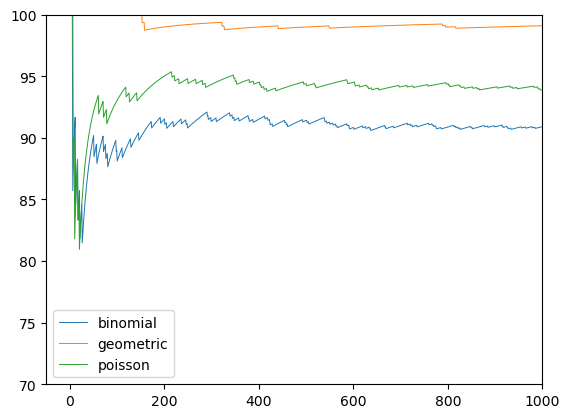

In [14]:
def calculate_percentage(array):
    percentages = []
    cumulative_sum = 0

    for i, value in enumerate(array):
        cumulative_sum += value
        if i == 0:
            percentage = 100 if value == 1 else 0
        else:
            percentage = (cumulative_sum / (i + 1)) * 100
        percentages.append(percentage)

    return percentages

percentages_b = calculate_percentage(arr_b)
percentages_g = calculate_percentage(arr_g)
percentages_p = calculate_percentage(arr_p)
plt.plot(percentages_b, linewidth=0.7, label = 'binomial')
plt.plot(percentages_g, linewidth=0.7, label = 'geometric')
plt.plot(percentages_p, linewidth=0.7, label = 'poisson')
plt.xlim([-50, 1000])
plt.ylim([70, 100])
plt.legend()
plt.show

In [18]:
df_per_b = pd.DataFrame(np.transpose(percentages_b), columns =['Retire_B_Per'])
df_per_g = pd.DataFrame(np.transpose(percentages_g), columns =['Retire_G_Per'])
df_per_p = pd.DataFrame(np.transpose(percentages_p), columns =['Retire_P_Per'])

In [19]:
result_df = pd.concat([df_b, df_p, df_g, df_per_b, df_per_g,df_per_p, df_cum_regret_p, df_cum_regret_b, df_cum_regret_g], axis=1, join='inner')
result_df.tail()

,Retire_B_0,Retire_B_1,Retire_B_2,Retire_B_3,Retire_B_4,Retire_B_5,Retire_P_0,Retire_P_1,Retire_P_2,Retire_P_3,...,Retire_G_2,Retire_G_3,Retire_G_4,Retire_G_5,Retire_B_Per,Retire_G_Per,Retire_P_Per,Retire_Reg_P,Retire_Reg_B,Retire_Reg_G
19995,0.0,37.451594,56.356517,92.705140,98.777034,39.112964,0.0,58.481809,89.333221,97.996048,...,96.204317,76.682952,8.596773,0.599596,96.869374,98.179636,98.019604,505,978,1534
19996,0.0,37.364449,56.125285,92.825838,98.777331,39.112964,0.0,58.387045,89.094147,98.002009,...,96.207562,76.682952,8.596773,0.599596,96.869530,98.179727,98.019703,505,978,1534
19997,0.0,37.345883,56.106156,92.930268,98.777334,39.112964,0.0,58.502154,88.980585,98.007253,...,96.208118,76.682952,8.596773,0.599596,96.869687,98.179818,98.019802,505,978,1534
19998,0.0,37.200178,55.850054,92.575593,98.784142,39.112964,0.0,58.571240,89.084229,98.007908,...,96.208214,76.682952,8.596773,0.599596,96.869843,98.179909,98.019901,505,978,1534
19999,0.0,37.172629,55.834961,92.680149,98.784561,39.112964,0.0,58.836222,89.152074,98.007961,...,96.222932,76.682952,8.596773,0.599596,96.870000,98.175000,98.020000,505,978,1534


In [20]:
result_df.to_csv('./retire.csv')